# Q-learning in OpenAI Gym: Frozen Lake

Using the tabular Q-learning algorithm, we will train an agent to navigate a slippery 4x4 grid to navigate from a start tile (`S`), to a goal tile (`G`), across frozen tiles (`F`) whilst avoiding the holes (`H`). Since the surface is slippery, an action results in a stochastic transition to a new state. Hence, the optimal policy is non-trivial to learn. The task is solved if the success rate is $\gtrsim 76\%$.

Author: Juvid Aryaman

In [1]:
import gym
import numpy as np
import sys
import matplotlib.pyplot as plt
import matplotlib as mpl
sys.path.append("..")
import utls
utls.reset_plots()

Load the Frozen Lake environment in `gym`

In [2]:
env = gym.make("FrozenLake-v0")

## Exploring the Frozen Lake environment

Let the agent follow a random policy, whereby the action is random for every state the agent finds itself in

In [3]:
state = env.reset()
for t in range(100):
    # show the environment as something a human can understand
    env.render() 
    # execute a random action
    action = env.action_space.sample() 
    print(state,action)
    # for that action, the environment emits a new state (observation) and reward. 
    # If we fall into a hole, H, the reward is 0. If we reach the goal, G, the reward is 1.
    # We keep going until one of these outcomes is achieved, or t > 100.
    state, reward, done, info = env.step(action) 
    if done:
        print("Episode finished after {} timesteps".format(t+1))
        break
print("reward = {}".format(reward))


SFFF
FHFH
FFFH
HFFG
0 0
  (Left)
SFFF
FHFH
FFFH
HFFG
0 3
  (Up)
SFFF
FHFH
FFFH
HFFG
0 1
  (Down)
SFFF
FHFH
FFFH
HFFG
1 0
Episode finished after 4 timesteps
reward = 0.0


An "episode" is a period of time where the agent interacts with the environment. Here, an episode ends when the agent either falls into a hole `H` or reaches the goal `G`, with a reward of 0 or 1 respectively.

The action-value function $Q_{\pi}(s,a)$ indicates how good it is, in state $s$, to first take action $a$ before continuing to follow policy $\pi$ (where a policy is a mapping from state to action) for all other next actions 

$$Q_{\pi}(s,a) = \mathbb{E}_{\pi}[\sum_{i=0}^\infty r_{t+i} | S_t = s, A_t = a].$$

When the policy $\pi$ is optimal, we label $Q$ as $Q^*$. $Q^*$ obeys a time consistency property called the Bellman equation

$$Q^*(s,a) = r(s,a) + \max_{a'}Q^*(s',a')$$

where $r(s,a)$ is the reward for being in state $s$ and taking action $a$, resulting in a transition to state $s'$ (note that this is the case when looking at past, realised, transitions). 

The tabular Q-learning control attempts to learn $Q^*(s,a)$. It is based on the Bellman equation, and is $\epsilon$-greedy. This means, with probability $1-\epsilon$, the agent chooses action $\text{argmax}_{a}Q^*(s,a)$, and otherwise choose a random action. We then update the policy according to
$$Q_{t+1}(s_t,a_t) \leftarrow Q_{t}(s_t, a_t) + \alpha \Big( r_t + \gamma \cdot \underset{b}{\max} Q_{t}(s_{t+1},b) - Q_{t}(s_t,a_t) \Big),$$
where $t$ is an index of time, which increases by 1 for every action (and is not reset for each episode). $\alpha$ is called the learning rate, which tells us how rapidly we update our action-value function. $\gamma$ is called the discount factor, which controls the weighting between immediate and future rewards.

## Perform tabular Q-learning on Frozen Lake

Initialise $Q^*$ randomly. $Q$ is simply a look-up table of all actions for all states. The state is a 4x4 grid (so 16 possible states), and there are 4 possible actions.

In [4]:
Q_init = np.random.uniform(size = [env.observation_space.n, env.action_space.n])
Q_init.shape

(16, 4)

Define hyperparameters

In [5]:
alpha = 0.1 # learning rate
gamma = 0.99 # discount factor

In [6]:
def Tabular_Q_learning(alpha, gamma, epsilons, episodes, Q_init, TMAX=100):
    Q = Q_init
    rewards = [] # for each episode
    ts = []
    for i in range(episodes):
        epsilon = epsilons[i]
        
        if i % 1000 == 0:
            print(i)
        # reset environment
        s = env.reset()
        t = 0
        r_all = 0.0
        done = False
        while t < TMAX:            
            # Choose action from epsilon-greedy policy using Q
            if np.random.uniform()<epsilon:
                a = env.action_space.sample() # make a random action
            else:
                a = np.argmax(Q[s,:])

            s_new, r, done, _ = env.step(a)

            # Update Q-Table
            Q[s,a] = Q[s,a] + alpha*(r + gamma*np.max(Q[s_new,:]) - Q[s,a])

            r_all += r
            s = s_new
            t += 1
            if done:
                ts.append(t)
                break
        rewards.append(r_all)
    rewards = np.array(rewards)
    print("Done.")
    return Q, rewards, ts

Investigate the effect of varying $\epsilon$

In [7]:
episodes = 5000
Q, rewards_e_0_5, ts = Tabular_Q_learning(alpha, gamma, 0.5*np.ones(episodes),episodes, Q_init)
Q, rewards_e_0_3, ts = Tabular_Q_learning(alpha, gamma, 0.3*np.ones(episodes),episodes, Q_init)
Q, rewards_e_0_1, ts = Tabular_Q_learning(alpha, gamma, 0.1*np.ones(episodes),episodes, Q_init)

0
1000
2000
3000
4000
Done.
0
1000
2000
3000
4000
Done.
0
1000
2000
3000
4000
Done.


Also investigate annealing $\epsilon$. Let's use an exponential rate of annealing, and pick a suitable rate by eye

Text(0, 0.5, '$\\epsilon$')

/home/juvid/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1238: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


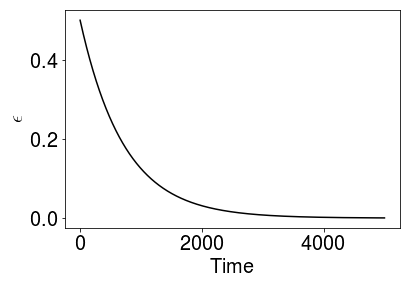

In [8]:
k = np.log(2)/(episodes/10)
t = np.arange(episodes)
fig, ax = plt.subplots(1,1)
ax.plot(t,0.5*np.exp(-k*t), '-k')
utls.remove_tex_axis(ax, ytick_fmt="%.1f")
ax.set_xlabel('Time')
ax.set_ylabel('$\epsilon$')

In [9]:
Q, rewards_e_anneal, ts = Tabular_Q_learning(alpha, gamma, 0.5*np.exp(-k*t),episodes, Q_init)

0
1000
2000
3000
4000
Done.


Bin the reward per episode to smooth the signal, so we may inspect it

In [10]:
def smooth_rewards(rewards, bin_length):
    nbins = int(len(rewards)/bin_length)
    mean_reward_binned = []
    std_reward_binned = []
    for i in np.arange(nbins,dtype=int):
        mean_reward = np.mean(rewards[i*bin_length:i*bin_length+bin_length])
        std_reward = np.std(rewards[i*bin_length:i*bin_length+bin_length],ddof=1)
        mean_reward_binned.append(mean_reward)
        std_reward_binned.append(std_reward)
    mean_reward_binned = np.array(mean_reward_binned)
    std_reward_binned = np.array(std_reward_binned)
    return mean_reward_binned, std_reward_binned, nbins

/home/juvid/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1238: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


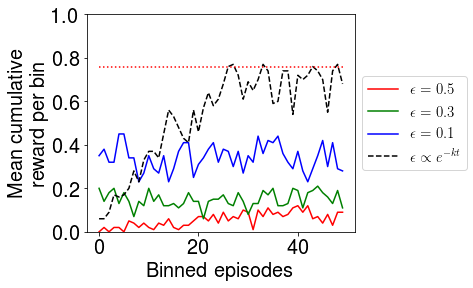

In [11]:
bin_length = 100
mean_reward_binned_5, std_reward_binned_5, nbins_5 = smooth_rewards(rewards_e_0_5, bin_length)
mean_reward_binned_3, std_reward_binned_3, nbins_3 = smooth_rewards(rewards_e_0_3, bin_length)
mean_reward_binned_1, std_reward_binned_1, nbins_1 = smooth_rewards(rewards_e_0_1, bin_length)
mean_reward_binned_a, std_reward_binned_a, nbins_a = smooth_rewards(rewards_e_anneal, bin_length)

fig, ax = plt.subplots(1,1)
ax.plot(np.arange(nbins_5), mean_reward_binned_5,'-r', label = "$\epsilon=0.5$")
ax.plot(np.arange(nbins_3), mean_reward_binned_3,'-g', label = "$\epsilon=0.3$")
ax.plot(np.arange(nbins_1), mean_reward_binned_1,'-b', label = "$\epsilon=0.1$")
ax.plot(np.arange(nbins_a), mean_reward_binned_a,'--k', label = "$\epsilon\propto e^{-kt}$")
x=np.arange(nbins_1)
ax.plot(x,0.76*np.ones(len(x)),':r')

utls.remove_tex_axis(ax,ytick_fmt="%.1f")
ax.set_xlabel('Binned episodes')
ax.set_ylabel('Mean cumulative\n reward per bin')
ax.set_ylim([0,1])

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

Dotted red line shows 76\% success rate. Reducing $\epsilon$ makes us learn better, and annealing $\epsilon$ is better still.

## Use the SARSA algorithm

The SARSA (state–action–reward–state–action) algorithm uses
$$Q_{t+1}(s_t,a_t) \leftarrow Q_{t}(s_t, a_t) + \alpha \Big( r_t + \gamma \cdot Q_{t}(s_{t+1},a_{t+1}) - Q_{t}(s_t,a_t) \Big)$$
Let's compare to the Q-learning algorithm...

In [12]:
def Tabular_Q_learning_SARSA(alpha, gamma, epsilons, episodes, Q_init, TMAX=100):
    Q = Q_init
    rewards = [] # for each episode
    ts = []
    for i in range(episodes):
        epsilon = epsilons[i]
        
        if i % 1000 == 0:
            print(i)
        # reset environment
        s = env.reset()
        a = 0
        t = 0
        r_all = 0.0
        done = False
        while t < TMAX:            
            # Choose action from epsilon-greedy policy using Q
            if np.random.uniform()<epsilon:
                a_new = env.action_space.sample() # make a random action
            else:
                a_new = np.argmax(Q[s,:])

            s_new, r, done, _ = env.step(a_new)

            # Update Q-Table
            Q[s,a] = Q[s,a] + alpha*(r + gamma*np.max(Q[s_new,a_new]) - Q[s,a])

            r_all += r
            s = s_new
            t += 1
            a = a_new
            if done:
                ts.append(t)
                break
        rewards.append(r_all)
    rewards = np.array(rewards)
    print("Done.")
    return Q, rewards, ts

In [13]:
Q, rewards_e_a_SARSA, ts = Tabular_Q_learning_SARSA(alpha, gamma, 0.5*np.exp(-k*t),episodes, Q_init)

0
1000
2000
3000
4000
Done.


In [14]:
mean_reward_binned_a_SARSA, std_reward_binned_a_SARSA, nbins_a_SARSA = smooth_rewards(rewards_e_a_SARSA, bin_length)

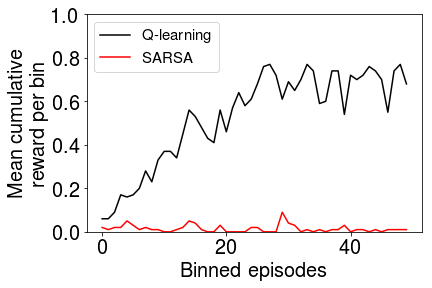

In [15]:
fig, ax = plt.subplots(1,1)
ax.plot(np.arange(nbins_a), mean_reward_binned_a,'-k', label = "Q-learning")
ax.plot(np.arange(nbins_a), mean_reward_binned_a_SARSA,'-r', label = "SARSA")

utls.remove_tex_axis(ax,ytick_fmt="%.1f")
ax.set_xlabel('Binned episodes')
ax.set_ylabel('Mean cumulative\n reward per bin')
ax.set_ylim([0,1])
ax.legend()

Hmmm... SARSA doesn't seem to be very good!!

To do: Convert to `TensorFlow`